# Categorical variables

Categorical variables are external factors that can influence a forecast. These variables take on one of a limited, fixed number of possible values, and induce a grouping of your observations.[^1]

For example, if you're forecasting daily product demand for a retailer, you could benefit from an event variable that may tell you what kind of event takes place on a given day, for example 'None', 'Sporting', or 'Cultural'.

To incorporate categorical variables in TimeGPT, you'll need to pair each point in your time series data with the corresponding external data.

[^1]: https://en.wikipedia.org/wiki/Categorical_variable

In [ ]:
#| hide
from nixtlats.utils import colab_badge

In [ ]:
#| echo: false
colab_badge('docs/tutorials/13_categorical_variables')

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nixtla/nixtla/blob/main/nbs/docs/tutorials/13_categorical_variables.ipynb)

In [ ]:
#| hide
from dotenv import load_dotenv

In [ ]:
#| hide
load_dotenv()

False

In [ ]:
import pandas as pd
from nixtlats import NixtlaClient

In [ ]:
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'my_api_key_provided_by_nixtla'
)

In [ ]:
#| hide
# nixtla_client = NixtlaClient()

Let's see an example on predicting sales of products of the [M5 dataset](https://nixtlaverse.nixtla.io/datasetsforecast/m5.html). The M5 dataset contains daily product demand (sales) for 10 retail stores in the US. 

First, we load the data using `datasetsforecast`. This returns:
- `Y_df`, containing the sales (`y` column), for each unique product (`unique_id` column) at every timestamp (`ds` column). 
- `X_df`, containing additional relevant information for each unique product (`unique_id` column) at every timestamp (`ds` column). 

In [ ]:
from datasetsforecast.m5 import M5
import os

Y_df, X_df, _ = M5.load(directory=os.getcwd())

Y_df.head(10)

,unique_id,ds,y
0,FOODS_1_001_CA_1,2011-01-29,3.0
1,FOODS_1_001_CA_1,2011-01-30,0.0
2,FOODS_1_001_CA_1,2011-01-31,0.0
3,FOODS_1_001_CA_1,2011-02-01,1.0
4,FOODS_1_001_CA_1,2011-02-02,4.0
5,FOODS_1_001_CA_1,2011-02-03,2.0
6,FOODS_1_001_CA_1,2011-02-04,0.0
7,FOODS_1_001_CA_1,2011-02-05,2.0
8,FOODS_1_001_CA_1,2011-02-06,0.0
9,FOODS_1_001_CA_1,2011-02-07,0.0


For this example, we will only keep the additional relevant information from the column `event_type_1`. This column is a _categorical variable_ that indicates whether an important event that might affect the sales of the product takes place at a certain date. 

In [ ]:
X_df = X_df[['unique_id', 'ds', 'event_type_1']]

X_df.head(10)

,unique_id,ds,event_type_1
0,FOODS_1_001_CA_1,2011-01-29,nan
1,FOODS_1_001_CA_1,2011-01-30,nan
2,FOODS_1_001_CA_1,2011-01-31,nan
3,FOODS_1_001_CA_1,2011-02-01,nan
4,FOODS_1_001_CA_1,2011-02-02,nan
5,FOODS_1_001_CA_1,2011-02-03,nan
6,FOODS_1_001_CA_1,2011-02-04,nan
7,FOODS_1_001_CA_1,2011-02-05,nan
8,FOODS_1_001_CA_1,2011-02-06,Sporting
9,FOODS_1_001_CA_1,2011-02-07,nan


As you can see, on February 6th 2011, there is a Sporting event. 

We will forecast the demand for a single product only. We choose a high selling food product identified by `FOODS_3_090_CA_3`.

In [ ]:
product = 'FOODS_3_090_CA_3'
Y_df_product = Y_df.query('unique_id == @product')
X_df_product = X_df.query('unique_id == @product')

We merge our two dataframes to create the dataset to be used in TimeGPT.

In [ ]:
df = Y_df_product.merge(X_df_product)

df.head(10)

,unique_id,ds,y,event_type_1
0,FOODS_3_090_CA_3,2011-01-29,108.0,nan
1,FOODS_3_090_CA_3,2011-01-30,132.0,nan
2,FOODS_3_090_CA_3,2011-01-31,102.0,nan
3,FOODS_3_090_CA_3,2011-02-01,120.0,nan
4,FOODS_3_090_CA_3,2011-02-02,106.0,nan
5,FOODS_3_090_CA_3,2011-02-03,123.0,nan
6,FOODS_3_090_CA_3,2011-02-04,279.0,nan
7,FOODS_3_090_CA_3,2011-02-05,175.0,nan
8,FOODS_3_090_CA_3,2011-02-06,186.0,Sporting
9,FOODS_3_090_CA_3,2011-02-07,120.0,nan


In order to use _categorical variables_ with TimeGPT, it is necessary to numerically encode the variables. We will use _one-hot encoding_ in this tutorial. 

We can one-hot encode the `event_type_1` column by using pandas built-in `get_dummies` functionality. After one-hot encoding the `event_type_1` variable, we can add it to the dataframe and remove the original column.

In [ ]:
event_type_1_ohe = pd.get_dummies(df['event_type_1'], dtype=int)
df = pd.concat([df, event_type_1_ohe], axis=1)
df = df.drop(columns = 'event_type_1')

df.tail(10)

,unique_id,ds,y,Cultural,National,Religious,Sporting,nan
1959,FOODS_3_090_CA_3,2016-06-10,140.0,0,0,0,0,1
1960,FOODS_3_090_CA_3,2016-06-11,151.0,0,0,0,0,1
1961,FOODS_3_090_CA_3,2016-06-12,87.0,0,0,0,0,1
1962,FOODS_3_090_CA_3,2016-06-13,67.0,0,0,0,0,1
1963,FOODS_3_090_CA_3,2016-06-14,50.0,0,0,0,0,1
1964,FOODS_3_090_CA_3,2016-06-15,58.0,0,0,0,0,1
1965,FOODS_3_090_CA_3,2016-06-16,116.0,0,0,0,0,1
1966,FOODS_3_090_CA_3,2016-06-17,124.0,0,0,0,0,1
1967,FOODS_3_090_CA_3,2016-06-18,167.0,0,0,0,0,1
1968,FOODS_3_090_CA_3,2016-06-19,118.0,0,0,0,1,0


As you can see, we have now added 5 columns, each with a binary indicator (`1` or `0`) whether there is a `Cultural`, `National`, `Religious`, `Sporting` or no (`nan`) event on that particular day. For example, on June 19th 2016, there is a `Sporting` event.

Let's turn to our forecasting task. We will forecast the first 7 days of February 2016. This includes 7 February 2016 - the date on which [Super Bowl 50](https://en.wikipedia.org/wiki/Super_Bowl_50) was held. Such large, national events typically impact retail product sales.

To use the encoded categorical variables in TimeGPT, we have to add them as future values. Therefore, we create a future values dataframe, that contains the `unique_id`, the timestamp `ds`, and the encoded categorical variables.

Of course, we drop the target column as this is normally not available - this is the quantity that we seek to forecast!

In [ ]:
future_ex_vars_df = df.drop(columns = ['y'])
future_ex_vars_df = future_ex_vars_df.query("ds >= '2016-02-01' & ds <= '2016-02-07'")

future_ex_vars_df.head(10)

,unique_id,ds,Cultural,National,Religious,Sporting,nan
1829,FOODS_3_090_CA_3,2016-02-01,0,0,0,0,1
1830,FOODS_3_090_CA_3,2016-02-02,0,0,0,0,1
1831,FOODS_3_090_CA_3,2016-02-03,0,0,0,0,1
1832,FOODS_3_090_CA_3,2016-02-04,0,0,0,0,1
1833,FOODS_3_090_CA_3,2016-02-05,0,0,0,0,1
1834,FOODS_3_090_CA_3,2016-02-06,0,0,0,0,1
1835,FOODS_3_090_CA_3,2016-02-07,0,0,0,1,0


Next, we limit our input dataframe to all but the 7 forecast days:

In [ ]:
df_train = df.query("ds < '2016-02-01'")

df_train.tail(10)

,unique_id,ds,y,Cultural,National,Religious,Sporting,nan
1819,FOODS_3_090_CA_3,2016-01-22,94.0,0,0,0,0,1
1820,FOODS_3_090_CA_3,2016-01-23,144.0,0,0,0,0,1
1821,FOODS_3_090_CA_3,2016-01-24,146.0,0,0,0,0,1
1822,FOODS_3_090_CA_3,2016-01-25,87.0,0,0,0,0,1
1823,FOODS_3_090_CA_3,2016-01-26,73.0,0,0,0,0,1
1824,FOODS_3_090_CA_3,2016-01-27,62.0,0,0,0,0,1
1825,FOODS_3_090_CA_3,2016-01-28,64.0,0,0,0,0,1
1826,FOODS_3_090_CA_3,2016-01-29,102.0,0,0,0,0,1
1827,FOODS_3_090_CA_3,2016-01-30,113.0,0,0,0,0,1
1828,FOODS_3_090_CA_3,2016-01-31,98.0,0,0,0,0,1


Let's call the `forecast` method, first _without_ the categorical variables.

In [ ]:
timegpt_fcst_without_cat_vars_df = nixtla_client.forecast(df=df_train, h=7, level=[80, 90])
timegpt_fcst_without_cat_vars_df.head()

INFO:nixtlats.nixtla_client:Validating inputs...
INFO:nixtlats.nixtla_client:Preprocessing dataframes...
INFO:nixtlats.nixtla_client:Inferred freq: D
INFO:nixtlats.nixtla_client:Restricting input...
c:\Users\ospra\OneDrive\Phd\Repositories\nixtla\nixtlats\nixtla_client.py:575: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Y_df = Y_df.groupby("unique_id").tail(new_input_size)
INFO:nixtlats.nixtla_client:Calling Forecast Endpoint...


,unique_id,ds,TimeGPT,TimeGPT-lo-90,TimeGPT-lo-80,TimeGPT-hi-80,TimeGPT-hi-90
0,FOODS_3_090_CA_3,2016-02-01,73.304092,53.449049,54.795078,91.813107,93.159136
1,FOODS_3_090_CA_3,2016-02-02,66.335518,47.510669,50.274136,82.396899,85.160367
2,FOODS_3_090_CA_3,2016-02-03,65.881630,36.218617,41.388896,90.374364,95.544643
3,FOODS_3_090_CA_3,2016-02-04,72.371864,-26.683115,25.097362,119.646367,171.426844
4,FOODS_3_090_CA_3,2016-02-05,95.141045,-2.084882,34.027078,156.255011,192.366971


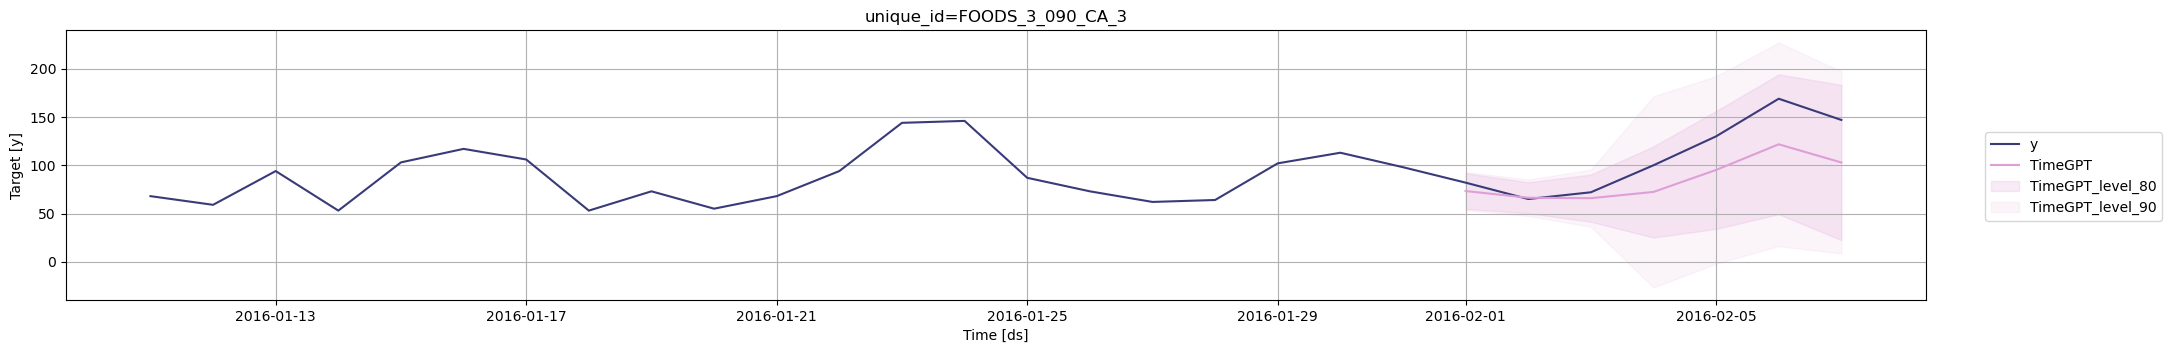

In [ ]:
nixtla_client.plot(
    df[['unique_id', 'ds', 'y']].query("ds <= '2016-02-07'"), 
    timegpt_fcst_without_cat_vars_df, 
    max_insample_length=28, 
    level=[80, 90], 
)

TimeGPT already provides a reasonable forecast, but it seems to somewhat underforecast the peak on the 6th of February 2016 - the day before the Super Bowl.

Let's call the `forecast` method again, now _with_ the categorical variables.

In [ ]:
timegpt_fcst_with_cat_vars_df = nixtla_client.forecast(df=df_train, X_df=future_ex_vars_df, h=7, level=[80, 90])
timegpt_fcst_with_cat_vars_df.head()

INFO:nixtlats.nixtla_client:Validating inputs...
INFO:nixtlats.nixtla_client:Preprocessing dataframes...
INFO:nixtlats.nixtla_client:Inferred freq: D
INFO:nixtlats.nixtla_client:Using the following exogenous variables: Cultural, National, Religious, Sporting, nan
INFO:nixtlats.nixtla_client:Calling Forecast Endpoint...


,unique_id,ds,TimeGPT,TimeGPT-lo-90,TimeGPT-lo-80,TimeGPT-hi-80,TimeGPT-hi-90
0,FOODS_3_090_CA_3,2016-02-01,70.661271,-0.204378,14.593343,126.729198,141.526919
1,FOODS_3_090_CA_3,2016-02-02,65.566941,-20.394295,11.654239,119.479643,151.528177
2,FOODS_3_090_CA_3,2016-02-03,68.510010,-33.713710,6.732952,130.287069,170.733731
3,FOODS_3_090_CA_3,2016-02-04,75.417702,-40.974637,4.751751,146.083653,191.810041
4,FOODS_3_090_CA_3,2016-02-05,97.340302,-57.385384,18.253823,176.426781,252.065988


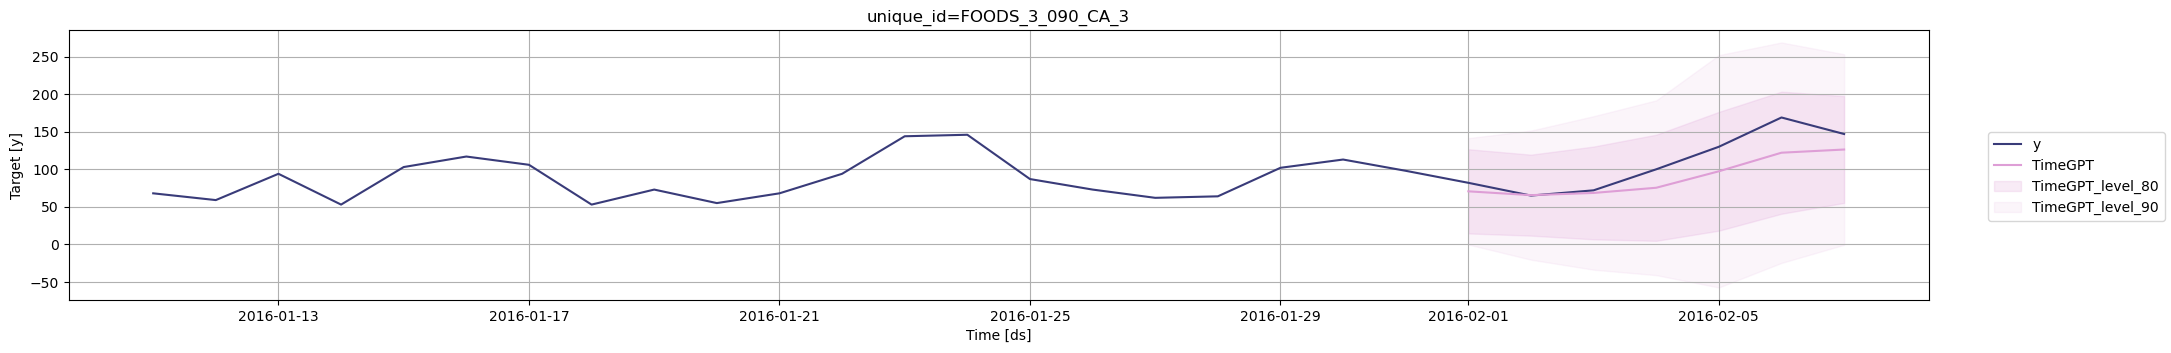

In [ ]:
nixtla_client.plot(
    df[['unique_id', 'ds', 'y']].query("ds <= '2016-02-07'"), 
    timegpt_fcst_with_cat_vars_df, 
    max_insample_length=28, 
    level=[80, 90], 
)

We now see that the forecast is closer to the actual observed value, which is the result of including the categorical variable in our forecast.